In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit as nk
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from sklearn import preprocessing, datasets, ensemble, model_selection
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.inspection import (partial_dependence, PartialDependenceDisplay, permutation_importance)

# Criação de dataset unificado

In [2]:
data_set_path = r"C:\Users\luiza\Documents\UFSC\TCC_Datasets\WESAD\WESAD"


In [3]:
# Lista para armazenar os dados combinados de todos os diretórios
all_data = []

# Lista de diretórios de S2 a S17
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    bvp=obj['signal']['wrist']['BVP'][:,0]
                    eda=obj['signal']['wrist']['EDA'][:,0]
                    temp=obj['signal']['wrist']['TEMP'][:,0]
                    label=obj['label']



In [4]:
fs_label = 700  # Hz
fs_temp_eda = 4  # Hz
fs_bvp = 64  # Hz

len_label = len(label)
len_temp_eda = len(temp)
len_bvp = len(bvp)

total_time = len_label / fs_label

time_label = np.linspace(0, total_time, len_label, endpoint=False)
time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)
time_bvp = np.linspace(0, total_time, len_bvp, endpoint=False)


interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')
interp_bvp = interp1d(time_bvp, bvp, kind='nearest', fill_value='extrapolate')

aligned_temp = interp_temp(time_label)
aligned_eda = interp_eda(time_label)
aligned_bvp = interp_bvp(time_label)

In [5]:
hr_data = []
folders = [f"S{i}" for i in range(2, 18)]


for folder_name in folders:
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

if hr_data:
    combined_hr_df = pd.concat(hr_data, ignore_index=True)
    # Converte para numpy array
    hr = combined_hr_df.iloc[:, 0].to_numpy()

fs_hr = 1  # Hz
len_hr = len(hr)
time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
aligned_hr = interp_hr(time_label)

In [6]:
numpy_data = np.column_stack((aligned_bvp, aligned_hr, aligned_eda, aligned_temp, label))
all_data.append(numpy_data)
combined_data = np.concatenate(all_data, axis=0)
column_names = ["bvp", "hr", "eda", "temp", "label"]
df = pd.DataFrame(data=combined_data, columns=column_names)

# 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset 
df = df[df['label'] != 7.0]
df= df[df['label'] != 6.0]
df= df[df['label'] != 5.0]
df = df.drop_duplicates()

In [7]:
df

,bvp,hr,eda,temp,label
0,-0.49,101.00,2.015176,33.39,0.0
6,-0.38,101.00,2.015176,33.39,0.0
17,-0.36,101.00,2.015176,33.39,0.0
20,-0.36,106.50,2.015176,33.39,0.0
28,-0.75,106.50,2.015176,33.39,0.0
...,...,...,...,...,...
4143942,-2.09,73.65,0.783331,31.81,0.0
4143951,-3.28,73.65,0.783331,31.81,0.0
4143962,-4.43,73.65,0.783331,31.81,0.0
4143973,-5.44,73.65,0.783331,31.81,0.0


### NORMALIZAR E CRIAR MIN, MEAN, MAX

In [8]:
def calculate_and_normalize_stats(df, column):
    min_vals, max_vals, mean_vals = [], [], []
    for i in range(0, len(df), 3):
        vals = df[column].iloc[i:i+3]
        min_vals.append(vals.min())
        max_vals.append(vals.max())
        mean_vals.append(vals.mean())
    stats_df = pd.DataFrame({f'{column}_min': min_vals, f'{column}_max': max_vals, f'{column}_mean': mean_vals})
    normalized_mean = preprocessing.normalize([stats_df[f'{column}_mean'].to_numpy()]).flatten()
    normalized_max = preprocessing.normalize([stats_df[f'{column}_max'].to_numpy()]).flatten()
    normalized_min = preprocessing.normalize([stats_df[f'{column}_min'].to_numpy()]).flatten()
    return pd.DataFrame({f'normalized_{column}_mean': normalized_mean,
                        f'normalized_{column}_max': normalized_max,
                        f'normalized_{column}_min': normalized_min})

# Calcular e normalizar estatísticas para temperatura, EDA e HR
df_temp = calculate_and_normalize_stats(df, 'temp')
df_eda = calculate_and_normalize_stats(df, 'eda')
df_hr = calculate_and_normalize_stats(df, 'hr')

# Combinar os dataframes normalizados
df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
df_normalizado.tail()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min,normalized_eda_mean,normalized_eda_max,normalized_eda_min,normalized_hr_mean,normalized_hr_max,normalized_hr_min
158904,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002401,0.002400,0.002402
158905,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002394,0.002400,0.002391
158906,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002390,0.002389,0.002391
158907,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002378,0.002376,0.002379
158908,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002378,0.002376,0.002379


In [9]:
label_mean = []
for i in range(0, len(df), 3):
    label = df['label'].iloc[i:i+3] 
    label_mean.append(label.mean())

label_stats = pd.DataFrame({'label_mean': label_mean})

# Aplicando algoritmos de classificação

In [10]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

### knn

In [11]:
k_nearest_neighbors = KNeighborsClassifier(n_neighbors=5, metric="minkowski", weights="uniform")
k_nearest_neighbors.fit(X_train, y_train.ravel())
y_pred_knn = k_nearest_neighbors.predict(X_test)
f1score   = f1_score        (y_test, y_pred_knn, average = 'macro')
recall    = recall_score    (y_test, y_pred_knn, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_knn)
AUC       = roc_auc_score   (y_test.ravel(), k_nearest_neighbors.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.991591047189687
acc = 0.9490067753235584
f1 = 0.9442958738494482
recall = 0.9461815087771754


### Logistic Regression

In [12]:
logistic_regression = LogisticRegression(penalty="l2", C=1.0, max_iter=999)
logistic_regression.fit(X_train, y_train.ravel())

y_pred_lr = logistic_regression.predict(X_test)
f1score   = f1_score        (y_test, y_pred_lr, average = 'macro')
recall    = recall_score    (y_test, y_pred_lr, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_lr)
AUC       = roc_auc_score   (y_test.ravel(), logistic_regression.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.7752635523657919
acc = 0.47582489039917775
f1 = 0.12896513495458875
recall = 0.2


### RF

In [13]:
clf = RandomForestClassifier(n_estimators=100,max_depth=15)
clf.fit(X_train, y_train.ravel())
y_pred_rf = clf.predict(X_test)

f1score   = f1_score        (y_test, y_pred_rf, average = 'macro')
recall    = recall_score    (y_test, y_pred_rf, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_rf)
AUC       = roc_auc_score   (y_test.ravel(), clf.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.9995511586443119
acc = 0.982946321817381
f1 = 0.981726961722557
recall = 0.983451905050838


### neural network

In [14]:
neural_network = MLPClassifier(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=999)

neural_network.fit(X_train, y_train.ravel())

y_pred_nn = neural_network.predict(X_test)
f1score   = f1_score        (y_test, y_pred_nn, average = 'macro')
recall    = recall_score    (y_test, y_pred_nn, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_nn)
AUC       = roc_auc_score   (y_test.ravel(), neural_network.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall) 

auc = 0.9171376725812521
acc = 0.6613387032492186
f1 = 0.4192426129417942
recall = 0.4298668066351678


### SVM

In [15]:
support_vector_machine = SVC(C=1.0, gamma=0.1, kernel="linear", tol=0.001, max_iter=9999, probability=True)
support_vector_machine.fit(X_train, y_train.ravel())
y_pred_svm = support_vector_machine.predict(X_test)

f1score   = f1_score        (y_test, y_pred_svm, average = 'macro')
recall    = recall_score    (y_test, y_pred_svm, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_svm)
AUC       = roc_auc_score   (y_test.ravel(), support_vector_machine.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall) 

c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=9999).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


auc = 0.8234288948114117
acc = 0.3615044154972416
f1 = 0.2956723635708373
recall = 0.3939929898922237


### feature importance

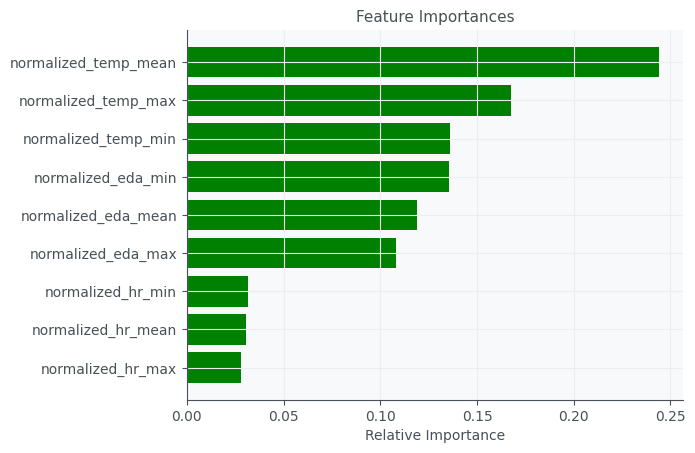

In [16]:
# -- feature importance graph
importances = clf.feature_importances_
indices = np.argsort(importances)
features = train_set.columns
plt.title('Feature Importances')
j = 9   # top j importance
plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance')
plt.show()

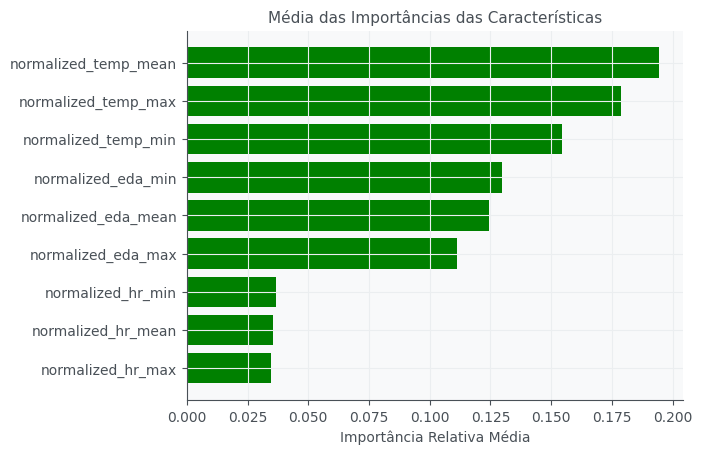

In [17]:
num_execucoes = 100
importancias_medias = np.zeros(X_train.shape[1])  # Lista para armazenar as importâncias médias das características

for _ in range(num_execucoes):
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=None) 
    clf.fit(X_train, y_train.ravel()) 
    
    importancias = clf.feature_importances_
    importancias_medias += importancias

importancias_medias /= num_execucoes # Calcular a média das importâncias das características

indices = np.argsort(importancias_medias)
plt.title('Média das Importâncias das Características')
j = 9   # top j importância
plt.barh(range(j), importancias_medias[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Importância Relativa Média')
plt.show()

# Criação de datasets individuais

In [18]:
dfs = {}
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)
    
    user_data = []

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    eda = obj['signal']['wrist']['EDA'][:, 0]
                    temp = obj['signal']['wrist']['TEMP'][:, 0]
                    label = obj['label']

                    len_label = len(label)
                    len_temp_eda = len(temp)

                    total_time = len_label / fs_label

                    time_label = np.linspace(0, total_time, len_label, endpoint=False)
                    time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)

                    interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
                    interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')

                    aligned_temp = interp_temp(time_label)
                    aligned_eda = interp_eda(time_label)

                    user_data.append((aligned_eda, aligned_temp, label))

    hr_data = []
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

    if hr_data:
        combined_hr_df = pd.concat(hr_data, ignore_index=True)
        hr = combined_hr_df.iloc[:, 0].to_numpy()

        len_hr = len(hr)
        time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
        interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
        aligned_hr = interp_hr(time_label)

        for eda, temp, label in user_data:
            numpy_data = np.column_stack((aligned_hr, eda, temp, label))
            if folder_name not in dfs:
                dfs[folder_name] = []
            dfs[folder_name].append(numpy_data)

for key in dfs:
    combined_data = np.concatenate(dfs[key], axis=0)
    column_names = ["hr", "eda", "temp", "label"]
    df = pd.DataFrame(data=combined_data, columns=column_names)
    
    df = df[df['label'] != 7.0]
    df = df[df['label'] != 6.0]
    df = df[df['label'] != 5.0]
    df = df.drop_duplicates()
    
    df_temp = calculate_and_normalize_stats(df, 'temp')
    df_eda = calculate_and_normalize_stats(df, 'eda')
    df_hr = calculate_and_normalize_stats(df, 'hr')

    df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
    
    label_mean = []
    for i in range(0, len(df), 3):
        label = df['label'].iloc[i:i+3] 
        label_mean.append(label.mean())
    label_stats = pd.DataFrame({'label_mean': label_mean})

    dfs[key] = pd.concat([df_normalizado, label_stats], axis=1)
    dfs[key] = dfs[key].drop_duplicates()

for i in list(range(2, 12)) + list(range(13, 18)):
    globals()[f'dfs{i}'] = dfs[f'S{i}']

### aplicando series temporais no s2

In [19]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn import metrics
from sktime.classification.kernel_based import RocketClassifier
from sklearn.metrics import mean_squared_error

In [20]:
X = dfs2.drop(columns=["label_mean"]) 
y = dfs2["label_mean"].astype(int)
X_train_skt, X_test_skt, y_train_skt, y_test_skt = temporal_train_test_split(X, y, test_size=0.3)
X_train_array = X_train_skt.values
X_test_array = X_test_skt.values
print("X_train_array shape:", X_train_array.shape)
print("X_test_array shape:", X_test_array.shape)

X_train_array shape: (5559, 9)
X_test_array shape: (2383, 9)


In [21]:
tsf = TimeSeriesForestClassifier(n_estimators=50, random_state=47)
tsf.fit(X_train_array, y_train_skt)
tsf_preds = tsf.predict(X_test_array)
print("TSF Accuracy: " + str(metrics.accuracy_score(y_test_skt, tsf_preds)))

TSF Accuracy: 0.44020142677297525


In [22]:
rocket = RocketClassifier(num_kernels=2000)
rocket.fit(X_train_array, y_train_skt)
y_pred = rocket.predict(X_test_array)
acc = accuracy_score(y_test_skt, y_pred)
acc


0.2698279479647503

In [23]:
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sklearn.linear_model import LinearRegression

variancia_label_mean = y_train_skt.var()
print(f"Variância da variável alvo (label_mean): {variancia_label_mean:.4f}")

results = {}
for i, column in enumerate(X_train_skt.columns):
    forecaster = make_reduction(LinearRegression(), strategy="direct", window_length=1)
    X_train_col = X_train_skt[[column]]
    X_test_col = X_test_skt[[column]]
    fh = ForecastingHorizon(y_test_skt.index, is_relative=False)
    forecaster.fit(y_train_skt, X=X_train_col, fh=fh)
    y_pred = forecaster.predict(fh, X=X_test_col)
    mse = mean_squared_error(y_test_skt, y_pred)
    
    results[column] = {
        "model": forecaster,
        "mse": mse,
        "y_test": y_test_skt,
        "y_pred": y_pred
    }

for column, result in results.items():
    mse = result['mse']
    print(f"Feature: {column}, MSE: {mse:.4f}")


Variância da variável alvo (label_mean): 0.6608
Feature: normalized_temp_mean, MSE: 7.0508
Feature: normalized_temp_max, MSE: 7.0527
Feature: normalized_temp_min, MSE: 7.0494
Feature: normalized_eda_mean, MSE: 7.4940
Feature: normalized_eda_max, MSE: 7.4942
Feature: normalized_eda_min, MSE: 7.4933
Feature: normalized_hr_mean, MSE: 7.3746
Feature: normalized_hr_max, MSE: 7.3759
Feature: normalized_hr_min, MSE: 7.3728


In [24]:
forecaster = make_reduction(LinearRegression(), strategy="direct", window_length=1)
fh = ForecastingHorizon(y_test_skt.index, is_relative=False)
forecaster.fit(y_train_skt, X=X_train_skt, fh=fh)
y_pred = forecaster.predict(fh, X=X_test_skt)
mse = mean_squared_error(y_test_skt, y_pred)
print(f"MSE do modelo geral: {mse:.4f}")

MSE do modelo geral: 7.2228


### criando a coluna de timestamps

In [25]:
import pandas as pd
import numpy as np
from sktime.regression.deep_learning import CNNRegressor
from sklearn.metrics import mean_squared_error
from sktime.forecasting.model_selection import temporal_train_test_split

def reshape_for_cnn(X):
    reshaped_X = []
    for i in range(len(X)):
        reshaped_X.append(X.iloc[i].values)
    reshaped_X = np.array(reshaped_X).astype('float32')
    return reshaped_X

X_train_cnn = reshape_for_cnn(X_train_skt)
X_test_cnn = reshape_for_cnn(X_test_skt)

print("X_train_cnn shape:", X_train_cnn.shape)
print("X_test_cnn shape:", X_test_cnn.shape)

cnn_regressor = CNNRegressor()
cnn_regressor.fit(X_train_cnn, y_train_skt)
y_pred = cnn_regressor.predict(X_test_cnn)

mse = mean_squared_error(y_test_skt, y_pred)
print(f"MSE do modelo CNNRegressor: {mse:.4f}")

variancia_label_mean = y_train_skt.var()
print(f"Variância da variável alvo (label_mean): {variancia_label_mean:.4f}")


X_train_cnn shape: (5559, 9)
X_test_cnn shape: (2383, 9)
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE do modelo CNNRegressor: 5.4152
Variância da variável alvo (label_mean): 0.6608


## Usar algoritmo treinado em datasets individuais

### random forest

In [26]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_rf = clf.predict(X)
    f1score = f1_score(y, y_pred_rf, average='macro')
    recall = recall_score(y, y_pred_rf, average='macro')
    accuracy = accuracy_score(y, y_pred_rf)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)
    
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc = sum(auc_list) / len(auc_list)
mean_accuracy = sum(accuracy_list) / len(accuracy_list)
mean_f1score = sum(f1score_list) / len(f1score_list)
mean_recall = sum(recall_list) / len(recall_list)

print("\nMédias das Métricas Considerando os 15 DataFrames:")
print('Média AUC =', mean_auc)
print('Média Accuracy =', mean_accuracy)
print('Média F1 Score =', mean_f1score)
print('Média Recall =', mean_recall)


 Dataset: dfs2
auc = 0.519827359842231
acc = 0.21858473936036263
f1 = 0.09060553962361881
recall = 0.21138460057697422

 Dataset: dfs3
auc = 0.44607565243610825
acc = 0.19168734491315137
f1 = 0.0694340659180129
recall = 0.19397929662751778

 Dataset: dfs4
auc = 0.4862396229887863
acc = 0.1715724244771495
f1 = 0.06496710000920429
recall = 0.2049736967957915

 Dataset: dfs5
auc = 0.5796037569721656
acc = 0.18945377683835798
f1 = 0.07397792914740851
recall = 0.1931950506198421

 Dataset: dfs6
auc = 0.5548278764896306
acc = 0.163777588330018
f1 = 0.06659284862843749
recall = 0.2033204600914568

 Dataset: dfs7
auc = 0.5
acc = 0.22881146528292562
f1 = 0.07448220390106576
recall = 0.2

 Dataset: dfs8
auc = 0.4991365216296443
acc = 0.20211515863689777
f1 = 0.06725317693059628
recall = 0.2

 Dataset: dfs9
auc = 0.5246059466206685
acc = 0.1728267297457126
f1 = 0.05938789661946139
recall = 0.16178362153856782

 Dataset: dfs10
auc = 0.5938063605004513
acc = 0.212742685261143
f1 = 0.07266061781637

### knn

In [27]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_knn = k_nearest_neighbors.predict(X)
    f1score = f1_score(y, y_pred_knn, average='macro')
    recall = recall_score(y, y_pred_knn, average='macro')
    accuracy = accuracy_score(y, y_pred_knn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)

    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc = sum(auc_list) / len(auc_list)
mean_accuracy = sum(accuracy_list) / len(accuracy_list)
mean_f1score = sum(f1score_list) / len(f1score_list)
mean_recall = sum(recall_list) / len(recall_list)

print("\nMédias das Métricas Considerando os 15 DataFrames:")
print('Média AUC =', mean_auc)
print('Média Accuracy =', mean_accuracy)
print('Média F1 Score =', mean_f1score)
print('Média Recall =', mean_recall)


 Dataset: dfs2
auc = 0.519827359842231
acc = 0.2280282044824981
f1 = 0.1449718932271763
recall = 0.2070540163914119

 Dataset: dfs3
auc = 0.44607565243610825
acc = 0.2294044665012407
f1 = 0.16367826874512809
recall = 0.29219239480545883

 Dataset: dfs4
auc = 0.4862396229887863
acc = 0.14304156984249936
f1 = 0.07143776494404405
recall = 0.21166905786704926

 Dataset: dfs5
auc = 0.5796037569721656
acc = 0.3143842474135054
f1 = 0.1529238440169418
recall = 0.2290396817197426

 Dataset: dfs6
auc = 0.5548278764896306
acc = 0.18044899119067917
f1 = 0.10468375280747391
recall = 0.13200486606997303

 Dataset: dfs7
auc = 0.5
acc = 0.41018038052878675
f1 = 0.20274804493900406
recall = 0.28607564020281717

 Dataset: dfs8
auc = 0.4991365216296443
acc = 0.27893654524089306
f1 = 0.12926545120835703
recall = 0.23048861308591398

 Dataset: dfs9
auc = 0.5246059466206685
acc = 0.2440863394441159
f1 = 0.12930855789883142
recall = 0.15859781918948576

 Dataset: dfs10
auc = 0.5938063605004513
acc = 0.09133

### logistic regression

In [28]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_lr = logistic_regression.predict(X)
    f1score = f1_score(y, y_pred_lr, average='macro')
    recall = recall_score(y, y_pred_lr, average='macro')
    accuracy = accuracy_score(y, y_pred_lr)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc = sum(auc_list) / len(auc_list)
mean_accuracy = sum(accuracy_list) / len(accuracy_list)
mean_f1score = sum(f1score_list) / len(f1score_list)
mean_recall = sum(recall_list) / len(recall_list)

print("\nMédias das Métricas Considerando os 15 DataFrames:")
print('Média AUC =', mean_auc)
print('Média Accuracy =', mean_accuracy)
print('Média F1 Score =', mean_f1score)
print('Média Recall =', mean_recall)


 Dataset: dfs2
auc = 0.519827359842231
acc = 0.4687736086628053
f1 = 0.1508265685905968
recall = 0.1880990887055271

 Dataset: dfs3
auc = 0.44607565243610825
acc = 0.5112903225806451
f1 = 0.17745023770382548
recall = 0.2138091264512904

 Dataset: dfs4
auc = 0.4862396229887863
acc = 0.5213013168086754
f1 = 0.150615441999254
recall = 0.19311334289813487

 Dataset: dfs5
auc = 0.5796037569721656
acc = 0.48748470352653245
f1 = 0.1391331957453564
recall = 0.18666666666666668

 Dataset: dfs6
auc = 0.5548278764896306
acc = 0.5849199583214928
f1 = 0.1570847112693971
recall = 0.19734739533397253

 Dataset: dfs7
auc = 0.5
acc = 0.42117617988633554
f1 = 0.1185429887855342
recall = 0.2

 Dataset: dfs8
auc = 0.4991365216296443
acc = 0.4049647473560517
f1 = 0.1263482048971008
recall = 0.17864275816363415

 Dataset: dfs9
auc = 0.5246059466206685
acc = 0.3710821998817268
f1 = 0.11853600944510034
recall = 0.17127260320709656

 Dataset: dfs10
auc = 0.5938063605004513
acc = 0.3921246923707957
f1 = 0.1236

### neural network

In [29]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_nn = neural_network.predict(X)
    f1score = f1_score(y, y_pred_nn, average='macro')
    recall = recall_score(y, y_pred_nn, average='macro')
    accuracy = accuracy_score(y, y_pred_nn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')
    
    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc = sum(auc_list) / len(auc_list)
mean_accuracy = sum(accuracy_list) / len(accuracy_list)
mean_f1score = sum(f1score_list) / len(f1score_list)
mean_recall = sum(recall_list) / len(recall_list)

print('Média AUC =', mean_auc)
print('Média Accuracy =', mean_accuracy)
print('Média F1 Score =', mean_f1score)
print('Média Recall =', mean_recall)


 Dataset: dfs2
auc = 0.519827359842231
acc = 0.29904306220095694
f1 = 0.13969029296522667
recall = 0.21346316780573021

 Dataset: dfs3
auc = 0.44607565243610825
acc = 0.20272952853598014
f1 = 0.09237193463795107
recall = 0.1624638066152279

 Dataset: dfs4
auc = 0.4862396229887863
acc = 0.21624064033049314
f1 = 0.09732428481642856
recall = 0.22152080344332856

 Dataset: dfs5
auc = 0.5796037569721656
acc = 0.39325842696629215
f1 = 0.18454609916439807
recall = 0.28068734604661016

 Dataset: dfs6
auc = 0.5548278764896306
acc = 0.3395851094060813
f1 = 0.15554695552214937
recall = 0.2666986257590284

 Dataset: dfs7
auc = 0.5
acc = 0.45305164319248825
f1 = 0.2164227336995573
recall = 0.2821172135504607

 Dataset: dfs8
auc = 0.4991365216296443
acc = 0.29347826086956524
f1 = 0.14147468249037148
recall = 0.2178025966983974

 Dataset: dfs9
auc = 0.5246059466206685
acc = 0.44988172678888233
f1 = 0.2187027605122132
recall = 0.3092459911293074

 Dataset: dfs10
auc = 0.5938063605004513
acc = 0.36942

### SVM

In [30]:
auc_list = []
accuracy_list = []
f1score_list = []
recall_list = []

for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_svm = support_vector_machine.predict(X)
    f1score = f1_score(y, y_pred_svm, average='macro')
    recall = recall_score(y, y_pred_svm, average='macro')
    accuracy = accuracy_score(y, y_pred_svm)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    auc_list.append(AUC)
    accuracy_list.append(accuracy)
    f1score_list.append(f1score)
    recall_list.append(recall)

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)

mean_auc = sum(auc_list) / len(auc_list)
mean_accuracy = sum(accuracy_list) / len(accuracy_list)
mean_f1score = sum(f1score_list) / len(f1score_list)
mean_recall = sum(recall_list) / len(recall_list)


print('\nMédia AUC =', mean_auc)
print('Média Accuracy =', mean_accuracy)
print('Média F1 Score =', mean_f1score)
print('Média Recall =', mean_recall)


 Dataset: dfs2
auc = 0.519827359842231
acc = 0.35696298161672124
f1 = 0.14501984883914293
recall = 0.17430749346222496

 Dataset: dfs3
auc = 0.44607565243610825
acc = 0.5468982630272953
f1 = 0.2224754111967243
recall = 0.26424072405528076

 Dataset: dfs4
auc = 0.4862396229887863
acc = 0.4805060676478182
f1 = 0.14315384615384616
recall = 0.17800095648015304

 Dataset: dfs5
auc = 0.5796037569721656
acc = 0.22082545333185005
f1 = 0.08876845018206955
recall = 0.0870997081911163

 Dataset: dfs6
auc = 0.5548278764896306
acc = 0.2833191247513498
f1 = 0.10031863156129465
recall = 0.09558964525407479

 Dataset: dfs7
auc = 0.5
acc = 0.2222634049913516
f1 = 0.0747440448346077
recall = 0.19343796468121802

 Dataset: dfs8
auc = 0.4991365216296443
acc = 0.28363689776733253
f1 = 0.12597796290821892
recall = 0.1585062959392698

 Dataset: dfs9
auc = 0.5246059466206685
acc = 0.0702247191011236
f1 = 0.03428983937917344
recall = 0.032412146025247356

 Dataset: dfs10
auc = 0.5938063605004513
acc = 0.17404

Todos as medias AUC deram iguais
Melhor media acc: lr com 0.44 (rf ficou em 2º)
Melhor media f1: RF
Melhor recall: rf

## Treinando e testando RF no s2

In [31]:
train_set = dfs2.drop(columns=["label_mean"])
labels = dfs2["label_mean"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

clfind = RandomForestClassifier(n_estimators=100,max_depth=15)
clfind.fit(X_train, y_train.ravel())
y_pred_rf = clfind.predict(X_test)

f1score   = f1_score        (y_test, y_pred_rf, average = 'macro')
recall    = recall_score    (y_test, y_pred_rf, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_rf)
AUC       = roc_auc_score   (y_test.ravel(), clfind.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.9991868437881666
acc = 0.9815358791439363
f1 = 0.9755708973526671
recall = 0.9768823583210882


## treinar em datasets individuais, testar no dataset geral


### knn, lr, rf

In [32]:
def evaluate_classifier(clf, train_set, labels, test_set, test_labels):
    clf.fit(train_set, labels.ravel())
    y_pred_rf = clf.predict(test_set)
    
    f1score = f1_score(test_labels, y_pred_rf, average='macro')
    recall = recall_score(test_labels, y_pred_rf, average='macro')
    accuracy = accuracy_score(test_labels, y_pred_rf)
    AUC = roc_auc_score(test_labels, clf.predict_proba(test_set), multi_class='ovr')
    
    return {
        'auc': AUC,
        'accuracy': accuracy,
        'f1': f1score,
        'recall': recall
    }

datasets = {f'dfs{i}': globals()[f'dfs{i}'] for i in range(2, 18) if i != 12}

test_set = df_normalizado
test_labels = np.array(label_stats, dtype=int)

classifiers = {
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, metric="minkowski", weights="uniform"),
    'Logistic Regression': LogisticRegression(penalty="l2", C=1.0, max_iter=999),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, random_state=30)
    #'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=999),
    #'Support Vector Machine': SVC(C=1.0, gamma=0.1, kernel="linear", tol=0.001, max_iter=9999, probability=True)
}

all_results = {}

for name, dataset in datasets.items():
    train_set = dataset.drop(columns=["label_mean"])
    labels = dataset["label_mean"].astype(int)
    
    dataset_results = {}
    for clf_name, clf in classifiers.items():
        metrics = evaluate_classifier(clf, train_set, labels, test_set, test_labels)
        dataset_results[clf_name] = metrics
    
    all_results[name] = dataset_results

for dataset_name, classifiers_metrics in all_results.items():
    print(f"\nResults for {dataset_name}:")
    for clf_name, metrics in classifiers_metrics.items():
        print(f"  {clf_name}:")
        print(f"    auc = {metrics['auc']}")
        print(f"    accuracy = {metrics['accuracy']}")
        print(f"    f1 = {metrics['f1']}")
        print(f"    recall = {metrics['recall']}")
    print()


Results for dfs2:
  K-Nearest Neighbors:
    auc = 0.5156841692427241
    accuracy = 0.47793235787958743
    f1 = 0.15835510800008085
    recall = 0.20479622741265593
  Logistic Regression:
    auc = 0.5049121141126681
    accuracy = 0.48464859678579997
    f1 = 0.1305759754422813
    recall = 0.2
  Random Forest:
    auc = 0.5189164266485851
    accuracy = 0.4576637083233389
    f1 = 0.1291643701961423
    recall = 0.1892738039743789


Results for dfs3:
  K-Nearest Neighbors:
    auc = 0.4509451598439487
    accuracy = 0.13372511393619574
    f1 = 0.08930547722345726
    recall = 0.13570627053164674
  Logistic Regression:
    auc = 0.7188497022272001
    accuracy = 0.48464859678579997
    f1 = 0.1305759754422813
    recall = 0.2
  Random Forest:
    auc = 0.452068578797786
    accuracy = 0.4766130966658671
    f1 = 0.14319430681920547
    recall = 0.19668398911160603


Results for dfs4:
  K-Nearest Neighbors:
    auc = 0.5013984050041994
    accuracy = 0.48009114895658433
    f1 = 0.

Médias das Métricas por Algoritmo:
K-Nearest Neighbors:
  Média AUC = 0.5343950392754101
  Média Accuracy = 0.41376828975773566
  Média F1 = 0.20858965499686782
  Média Recall = 0.2548295056394062

Logistic Regression:
  Média AUC = 0.5395468140143785
  Média Accuracy = 0.48464859678580013
  Média F1 = 0.1305759754422813
  Média Recall = 0.20000000000000007

Random Forest:
  Média AUC = 0.546315758320809
  Média Accuracy = 0.439769728951787
  Média F1 = 0.20291442906731913
  Média Recall = 0.2634184291048414

### nn

In [33]:
nn_classifier = {'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=999)}

results_nn = {}

for name, dataset in datasets.items():
    train_set = dataset.drop(columns=["label_mean"])
    labels = dataset["label_mean"].astype(int)
    
    dataset_results = {}
    for clf_name, clf in nn_classifier.items():
        metrics = evaluate_classifier(clf, train_set, labels, test_set, test_labels)
        dataset_results[clf_name] = metrics
    
    results_nn[name] = dataset_results

for dataset_name, classifiers_metrics in results_nn.items():
    print(f"\nResults for {dataset_name} - Neural Network:")
    for clf_name, metrics in classifiers_metrics.items():
        print(f"  {clf_name}:")
        print(f"    auc = {metrics['auc']}")
        print(f"    accuracy = {metrics['accuracy']}")
        print(f"    f1 = {metrics['f1']}")
        print(f"    recall = {metrics['recall']}")
    print()

c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the opti


Results for dfs2 - Neural Network:
  Neural Network:
    auc = 0.638161716188875
    accuracy = 0.46426001439194053
    f1 = 0.13430995218544456
    recall = 0.19281522533565834


Results for dfs3 - Neural Network:
  Neural Network:
    auc = 0.5340967565659719
    accuracy = 0.17822019668985367
    f1 = 0.11655705450565357
    recall = 0.17438012525187765


Results for dfs4 - Neural Network:
  Neural Network:
    auc = 0.5048061015839568
    accuracy = 0.4684576637083233
    f1 = 0.1277305428384565
    recall = 0.19331848552338532


Results for dfs5 - Neural Network:
  Neural Network:
    auc = 0.5763104101567538
    accuracy = 0.4673782681698249
    f1 = 0.13753796600877194
    recall = 0.19355582028394996


Results for dfs6 - Neural Network:
  Neural Network:
    auc = 0.36163049156183813
    accuracy = 0.46713840249460303
    f1 = 0.1278726198292843
    recall = 0.19277406582529077


Results for dfs7 - Neural Network:
  Neural Network:
    auc = 0.6040070882103193
    accuracy = 0

### svm

In [34]:
svc_classifier = {'Support Vector Machine': SVC(C=1.0, gamma=0.1, kernel="linear", tol=0.001, max_iter=9999, probability=True)}

results_svc = {}

for name, dataset in datasets.items():
    train_set = dataset.drop(columns=["label_mean"])
    labels = dataset["label_mean"].astype(int)
    
    dataset_results = {}
    for clf_name, clf in svc_classifier.items():
        metrics = evaluate_classifier(clf, train_set, labels, test_set, test_labels)
        dataset_results[clf_name] = metrics
    
    results_svc[name] = dataset_results

for dataset_name, classifiers_metrics in results_svc.items():
    print(f"\nResults for {dataset_name} - Support Vector Machine:")
    for clf_name, metrics in classifiers_metrics.items():
        print(f"  {clf_name}:")
        print(f"    auc = {metrics['auc']}")
        print(f"    accuracy = {metrics['accuracy']}")
        print(f"    f1 = {metrics['f1']}")
        print(f"    recall = {metrics['recall']}")
    print()


Results for dfs2 - Support Vector Machine:
  Support Vector Machine:
    auc = 0.6171766688485081
    accuracy = 0.48464859678579997
    f1 = 0.1305759754422813
    recall = 0.2


Results for dfs3 - Support Vector Machine:
  Support Vector Machine:
    auc = 0.6474849135458802
    accuracy = 0.48464859678579997
    f1 = 0.1305759754422813
    recall = 0.2


Results for dfs4 - Support Vector Machine:
  Support Vector Machine:
    auc = 0.4828221418065938
    accuracy = 0.4839289997601343
    f1 = 0.130466413386145
    recall = 0.19970304380103934


Results for dfs5 - Support Vector Machine:
  Support Vector Machine:
    auc = 0.5854813663817804
    accuracy = 0.48464859678579997
    f1 = 0.1305759754422813
    recall = 0.2


Results for dfs6 - Support Vector Machine:
  Support Vector Machine:
    auc = 0.5658221165170833
    accuracy = 0.48464859678579997
    f1 = 0.1305759754422813
    recall = 0.2


Results for dfs7 - Support Vector Machine:
  Support Vector Machine:
    auc = 0.5635

## rf com diferentes porcentagem no dataset geral

#### 10%

#### 20%

#### 30%

#### 40%

#### 50%